In [1]:
import requests
import time
import datetime
import math
import re
import lxml.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

from pandas.io.json import json_normalize
from urllib.request import urlopen
from urllib.parse import quote_plus
from bs4 import BeautifulSoup
from selenium import webdriver

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
## 한글 폰트
import matplotlib.font_manager as fm
import matplotlib as mpl

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')

for font in font_list:
    if 'Nanum' in font:
        print(font)
        
print()
print(mpl.matplotlib_fname())

plt.rcParams["font.family"] = 'NanumGothic'

## 마이너스 부호
mpl.rcParams['axes.unicode_minus'] = False

/Library/Fonts/NanumSquareRoundR.ttf
/System/Library/AssetsV2/com_apple_MobileAsset_Font6/3b0bb049516d6dd825e1cd8731587ca7415517ff.asset/AssetData/NanumScript.ttc
/Library/Fonts/NanumMyeongjoBold.ttf
/Library/Fonts/NanumBarunpenRegular.ttf
/Library/Fonts/NanumGothicLight.ttf
/Library/Fonts/NanumSquareLight.ttf
/Library/Fonts/NanumPen.ttf
/Library/Fonts/NanumGothicBold.ttf
/Library/Fonts/NanumSquareRoundB.ttf
/Library/Fonts/NanumSquareRoundL.ttf
/Library/Fonts/NanumSquareRegular.ttf
/System/Library/AssetsV2/com_apple_MobileAsset_Font6/5c10807185ddbca859bc0b3ecefe55ebb1985aa9.asset/AssetData/NanumMyeongjo.ttc
/Library/Fonts/NanumBarunGothic.ttf
/Library/Fonts/NanumGothicExtraBold.ttf
/Library/Fonts/NanumBarunGothicUltraLight.ttf
/Library/Fonts/NanumBarunpenBold.ttf
/Library/Fonts/NanumBarunGothicBold.ttf
/System/Library/AssetsV2/com_apple_MobileAsset_Font6/ee9e9584cd1a5f676e03a9efcc80783bc7e12e2c.asset/AssetData/NanumGothic.ttc
/Library/Fonts/NanumBrush.ttf
/Library/Fonts/NanumGothic.ttf

In [3]:
VERSION = '11.16.1'

# CHAMPION

## 전체 챔프 데이터

In [6]:
#champion info load
champ_req = requests.get('http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/champion.json')
champ_ls = list(champ_req.json()['data'].keys())
champ_df = pd.DataFrame()

for i in range(len(champ_ls)):
    pre_df = json_normalize(champ_req.json()['data'][champ_ls[i]])
    champ_df = champ_df.append(pre_df)
    
#column 정리
champ_df.columns = champ_df.columns.str.strip().str.replace('info.', '')
champ_df.columns = champ_df.columns.str.strip().str.replace('stats.', '')

champ_df['tag1'] = champ_df['tags'].apply(lambda x: x[0])
champ_df['tag2'] = champ_df['tags'].apply(lambda x: x[1] if len(x) == 2 else None)

champ_df.drop(columns=['version', 'tags', 'blurb', 'image.full', 'image.group', 'image.h', 'image.sprite', 'image.w', 'image.x', 'image.y', 'title'], inplace=True)

champ_df.head()

id  key     name     partype  attack  defense  magic  difficulty  \
0   Aatrox  266   Aatrox  Blood Well       8        4      3           4   
0     Ahri  103     Ahri        Mana       3        4      8           5   
0    Akali   84    Akali      Energy       5        3      8           7   
0   Akshan  166   Akshan        Mana       0        0      0           0   
0  Alistar   12  Alistar        Mana       6        9      5           7   

      hp  hpperlevel  ...  mpregen  mpregenperlevel  crit  critperlevel  \
0  580.0          90  ...    0.000              0.0     0             0   
0  526.0          92  ...    8.000              0.8     0             0   
0  500.0         105  ...   50.000              0.0     0             0   
0  560.0          90  ...    8.175              0.7     0             0   
0  600.0         106  ...    8.500              0.8     0             0   

   attackdamage  attackdamageperlevel  attackspeedperlevel  attackspeed  \
0          60.0                  5.00                2.500        0.651   
0          53.0                  3.00                2.000        0.668   
0          62.0                  3.30                3.200        0.625   
0          52.0                  3.50                4.000        0.638   
0          62.0                  3.75                2.125        0.625   

       tag1      tag2  
0   Fighter      Tank  
0      Mage  Assassin  
0  Assassin      None  
0  Marksman  Assassin  
0      Tank   Support  

[5 rows x 30 columns]

## 포지션별 챔피언 구분

### OP.GG에서 챔피언별 포지션 및 해당 포지션 비율 불러와서 정리+저장

In [7]:
positions = ['Top', 'Jungle', 'Middle', 'Bottom', 'Support']

position_abbre = {
    'Top':'TOP',
    'Jungle':'JUG',
    'Middle':'MID',
    'Bottom':'ADC',
    'Support':'SUP'
}

In [11]:
position_df = {}

for position in positions:
    position_df[position] = pd.DataFrame(columns=['rate'])
    
for champ in champ_df['id'].values:
    url = f'https://www.op.gg/champion/{champ.lower()}/statistics/top/build'
    
    html = urlopen(url)
    bsObject = BeautifulSoup(html, 'html.parser')
    contents = bsObject.select_one('body > div.l-wrap.l-wrap--champion > div.l-container > div > div.l-champion-statistics-header > div > ul')

    for li in contents.find_all('li'):
        spans = li.find_all('span')

        position = spans[0].get_text()
        rate = float(spans[1].get_text()[:-1])
        
        position_df[position].loc[champ,'rate'] = rate
        

for position in positions:
    position_df[position].reset_index(inplace=True)
    position_df[position].rename(columns={'index':'id'}, inplace=True)
    position_df[position].to_csv(f'champion_data/{position_abbre[position].lower()}_champ_{VERSION}.csv')

### 저장해둔 포지션별 챔피언 데이터 로드

In [6]:
position_df = {}

for position in ['Top', 'Jungle', 'Middle', 'Bottom', 'Support']:
    position_df[position] = pd.read_csv(f'champion_data/{position}_champ_{VERSION}.csv')
    position_df[position].rename(columns={'Unnamed: 0':'id'}, inplace=True)

## 스탯별로 분류

In [7]:
champ_df.columns

Index(['id', 'key', 'name', 'partype', 'attack', 'defense', 'magic',
       'difficulty', 'hp', 'hpperlevel', 'mp', 'mpperlevel', 'movespeed',
       'armor', 'armorperlevel', 'spellblock', 'spellblockperlevel',
       'attackrange', 'hpregen', 'hpregenperlevel', 'mpregen',
       'mpregenperlevel', 'crit', 'critperlevel', 'attackdamage',
       'attackdamageperlevel', 'attackspeedperlevel', 'attackspeed', 'tag1',
       'tag2'],
      dtype='object')

In [8]:
champ_stats = ['attack', 'defense', 'magic', 'hp', 'mp', 'movespeed', 'armor', 'spellblock', 'attackrange', 'hpregen', 'mpregen', 'crit', 'attackdamage', 'attackspeed']
champ_stat_perlevel = ['hpperlevel', 'mpperlevel', 'armorperlevel', 'spellblockperlevel', 'hpregenperlevel', 'mpregenperlevel', 'critperlevel', 'attackdamageperlevel', 'attackspeedperlevel']

### 챔프 스탯별로 등급 설정

In [9]:
for stat in champ_stats:
    level_num = 7
    
    while True:
        try:
            champ_df[stat+'_level'] = pd.cut(champ_df[stat], level_num, labels=range(1,level_num+1))
            break
            
        except ValueError as e:
            level_num -= 1
            
champ_df.head()

id  key     name     partype  attack  defense  magic  difficulty  \
0   Aatrox  266   Aatrox  Blood Well       8        4      3           4   
0     Ahri  103     Ahri        Mana       3        4      8           5   
0    Akali   84    Akali      Energy       5        3      8           7   
0   Akshan  166   Akshan        Mana       0        0      0           0   
0  Alistar   12  Alistar        Mana       6        9      5           7   

      hp  hpperlevel  ...  mp_level  movespeed_level  armor_level  \
0  580.0          90  ...         1                6            5   
0  526.0          92  ...         1                3            1   
0  500.0         105  ...         1                6            2   
0  560.0          90  ...         1                3            3   
0  600.0         106  ...         1                3            7   

   spellblock_level  attackrange_level  hpregen_level  mpregen_level  \
0                 4                  1              1              1   
0                 3                  6              3              2   
0                 6                  1              6              7   
0                 3                  5              2              2   
0                 4                  1              6              2   

   crit_level  attackdamage_level  attackspeed_level  
0           4                   5                  4  
0           4                   3                  5  
0           4                   5                  4  
0           4                   3                  4  
0           4                   5                  4  

[5 rows x 44 columns]

In [11]:
for stat in champ_stat_perlevel:
    level_num = 7
    
    while True:
        try:
            champ_df[stat+'_level'] = pd.cut(champ_df[stat], level_num, labels=range(1,level_num+1))
            break
            
        except ValueError as e:
            level_num -= 1
            
champ_df.head()

id  key     name     partype  attack  defense  magic  difficulty  \
0   Aatrox  266   Aatrox  Blood Well       8        4      3           4   
0     Ahri  103     Ahri        Mana       3        4      8           5   
0    Akali   84    Akali      Energy       5        3      8           7   
0   Akshan  166   Akshan        Mana       0        0      0           0   
0  Alistar   12  Alistar        Mana       6        9      5           7   

      hp  hpperlevel  ...  attackspeed_level  hpperlevel_level  \
0  580.0          90  ...                  4                 4   
0  526.0          92  ...                  5                 4   
0  500.0         105  ...                  4                 6   
0  560.0          90  ...                  4                 4   
0  600.0         106  ...                  4                 6   

   mpperlevel_level  armorperlevel_level  spellblockperlevel_level  \
0                 1                    6                         5   
0                 3                    6                         1   
0                 1                    6                         5   
0                 4                    5                         1   
0                 4                    6                         5   

   hpregenperlevel_level  mpregenperlevel_level  critperlevel_level  \
0                      4                      1                   4   
0                      2                      6                   4   
0                      1                      1                   4   
0                      2                      5                   4   
0                      3                      6                   4   

   attackdamageperlevel_level  attackspeedperlevel_level  
0                           7                          3  
0                           5                          3  
0                           5                          4  
0                           5                          5  
0                           6                          3  

[5 rows x 53 columns]

### 챔프 스탯 등급별로 출력

============attack============

7


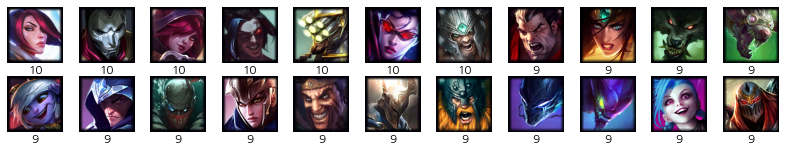


6


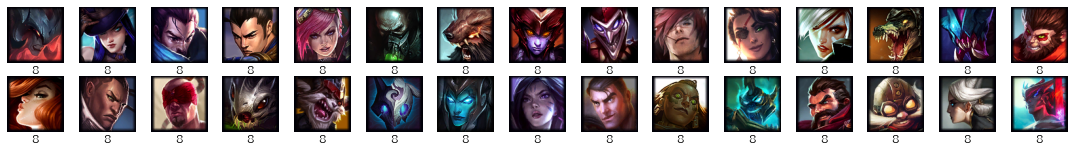


5


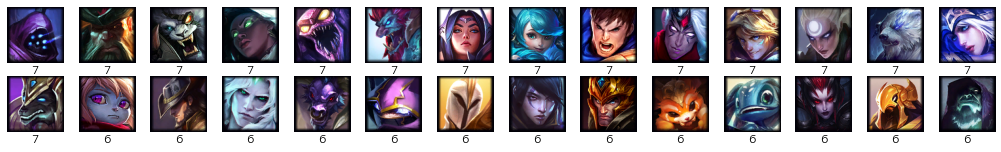


4


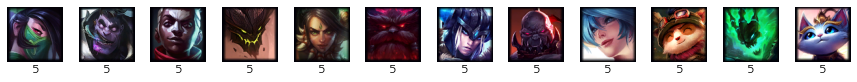


3


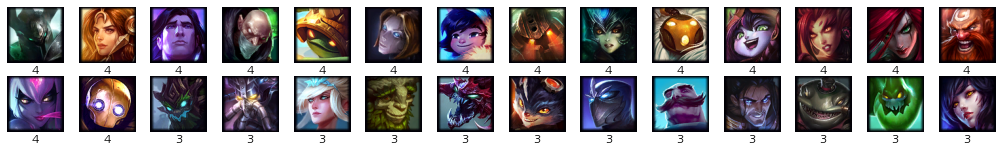


2


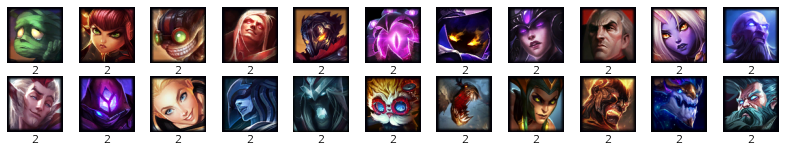


1


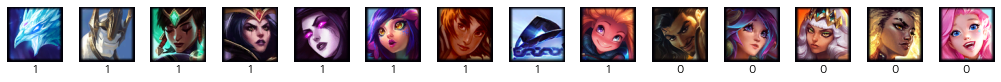

In [181]:
for stat in champ_stats[:1]:
    print(f'{stat:=^30}\n')
    
    levels = champ_df.sort_values(stat, ascending=False)[stat+'_level'].values.unique()
    
    for l in levels:
        print(l)
        
        ## 등급별로 정렬된 임시 DataFrame 생성
        temp_df = champ_df.loc[champ_df[stat+'_level'] == l].sort_values(stat, ascending=False)
        temp_df.set_index('id', inplace=True)
        champ_num = len(temp_df)
        
        ## figure grid 설정
        if champ_num >= 20:
            nrows = champ_num // 20 + 1
            ncols = math.ceil(champ_num / nrows)
        else:
            nrows = 1
            ncols = champ_num
        
        figure, axes = plt.subplots(figsize=(1*ncols,1*nrows), nrows=nrows, ncols=ncols)
        
        for n, champ_id in enumerate(temp_df.index):
            val = temp_df.loc[champ_id, stat]
            im = img.imread(f'champion_img/{champ_id}.png')
            
            if champ_num == 1: ax = axes
            elif nrows == 1: ax = axes[n]
            else: 
                ax = axes[n//ncols][n%ncols]
                        
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(val, y=-0.3)
            
        for i in range(n+1, nrows*ncols):
            ax = axes[i//ncols][i%ncols]
            ax.axis('off')
        
        plt.tight_layout(pad=0.5)
        plt.show()
        print()
    print()

### 챔프 스탯 포지션별 + 등급별로 출력

============Bottom============

----------hpperlevel----------

Level = 5


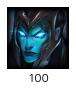


Level = 4


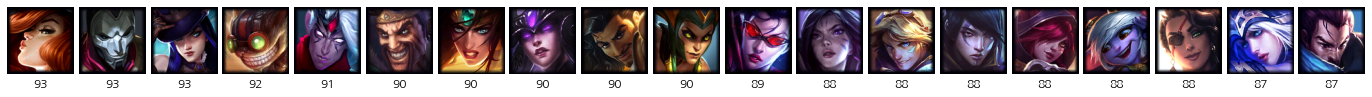


Level = 3


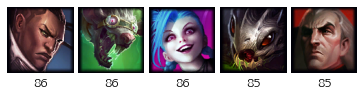



----------mpperlevel----------

Level = 6


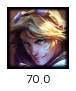


Level = 5


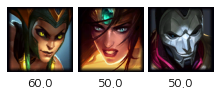


Level = 4


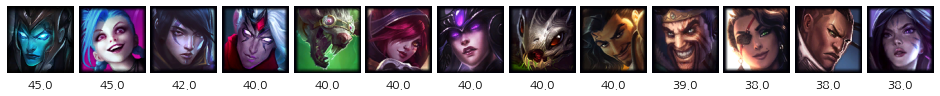


Level = 3


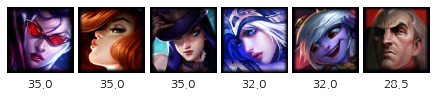


Level = 2


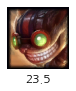


Level = 1


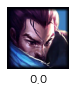



--------armorperlevel---------

Level = 7


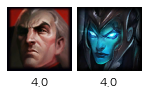


Level = 6


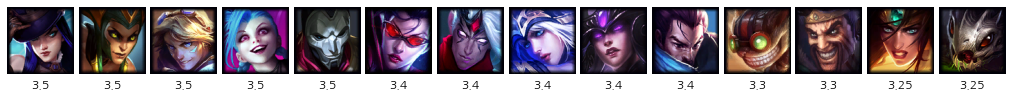


Level = 5


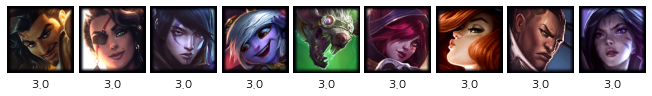



------spellblockperlevel------

Level = 5


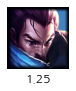


Level = 1


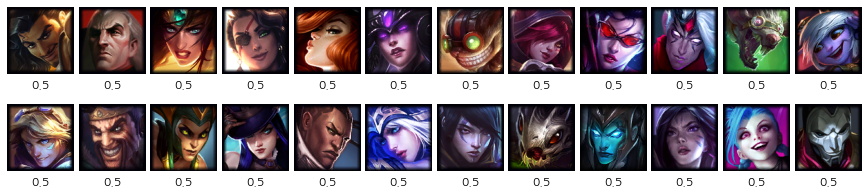



-------hpregenperlevel--------

Level = 3


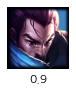


Level = 2


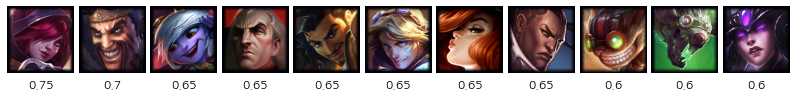


Level = 1


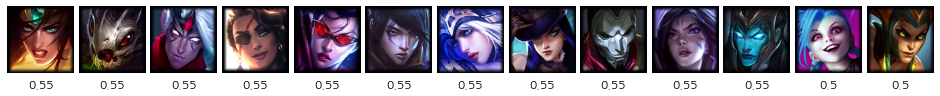



-------mpregenperlevel--------

Level = 7


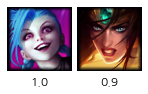


Level = 6


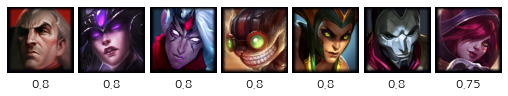


Level = 5


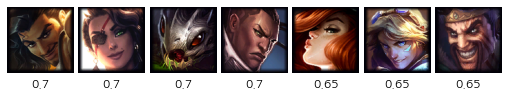


Level = 4


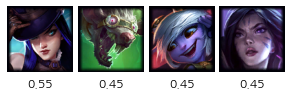


Level = 3


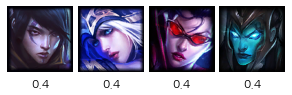


Level = 1


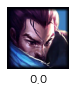



---------critperlevel---------

Level = 4


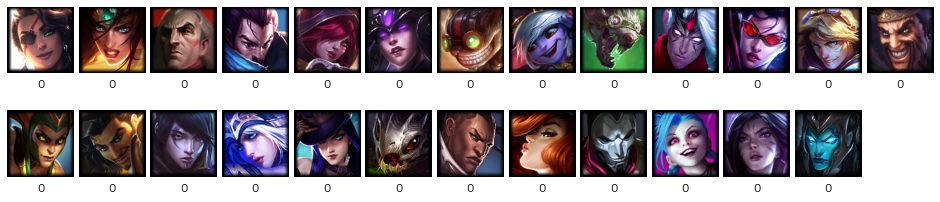



-----attackdamageperlevel-----

Level = 7


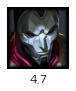


Level = 6


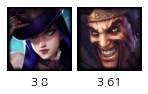


Level = 5


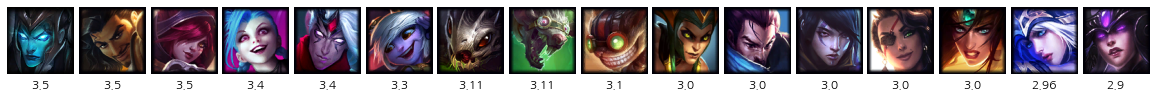


Level = 4


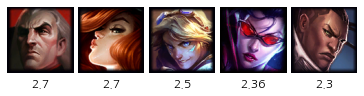


Level = 3


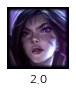



-----attackspeedperlevel------

Level = 5


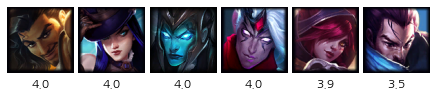


Level = 4


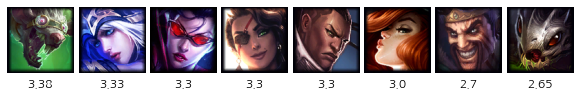


Level = 3


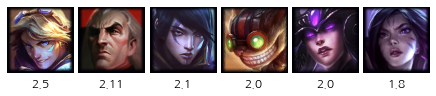


Level = 2


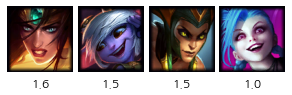


Level = 1


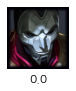

In [12]:
# position = 'Top'
# position = 'Jungle'
#position = 'Middle'
position = 'Bottom'
# position = 'Suppoter'

print(f'{position:=^30}\n')

for stat in champ_stat_perlevel:
    print(f'{stat:-^30}\n')
    
    levels = champ_df.sort_values(stat, ascending=False)[stat+'_level'].values.unique()
    
    for l in levels:

        ## 등급별로 정렬된 임시 DataFrame 생성
        temp_df = champ_df.loc[champ_df[stat+'_level'] == l].sort_values(stat, ascending=False)
        temp_df.set_index('id', inplace=True)
        
        for champ_id in temp_df.index:
            if champ_id not in position_df[position]['id'].values:
                temp_df.drop(index=champ_id, inplace=True)
                
        champ_num = len(temp_df)
        if champ_num == 0: continue
        
        
        ## figure grid 설정
        if champ_num >= 20:
            nrows = champ_num // 20 + 1
            ncols = math.ceil(champ_num / nrows)
        else:
            nrows = 1
            ncols = champ_num
        
        print(f'Level = {l}')
        figure, axes = plt.subplots(figsize=(1*ncols,1*nrows+1), nrows=nrows, ncols=ncols)
#         figure.suptitle(f'Level = {l}', weight='bold', size=15)
        
        for n, champ_id in enumerate(temp_df.index):
            val = temp_df.loc[champ_id, stat]
            im = img.imread(f'champion_img/{champ_id}.png')
            
            if champ_num == 1: ax = axes
            elif nrows == 1: ax = axes[n]
            else: 
                ax = axes[n//ncols][n%ncols]
                        
            ax.imshow(im)
            ax.axis('off')
            ax.set_title(val, y=-0.3)
            
        for i in range(n+1, nrows*ncols):
            ax = axes[i//ncols][i%ncols]
            ax.axis('off')
        
        plt.tight_layout(pad=0.5)
        plt.show()
        print()
    print()

### 챔프 태그 특성으로 분류

In [12]:
print(champ_df['tag1'].unique())
print(champ_df['tag2'].unique())

['Fighter' 'Mage' 'Assassin' 'Marksman' 'Tank' 'Support']
['Tank' 'Assassin' None 'Support' 'Mage' 'Marksman' 'Fighter']


In [ ]:
for tag1 in champ_df['tag1'].unique():
    print(f'{tag1:=^30}\n')
    
    temp_df = champ_df.loc[champ_df['tag1'] == tag1]
    temp_df.set_index('id', inplace=True)
    champ_num = len(temp_df)
    
    figure, axes = plt.subplots(figsize=(1*champ_num,1), nrows=1, ncols=champ_num)
    for n, champ_id in enumerate(temp_df.index):
        im = img.imread(f'champion_img/{champ_id}.png')
        axes[n].imshow(im)
        axes[n].axis('off')
    plt.show()
    print()
print()
    
    
for tag2 in champ_df['tag2'].unique():
    if tag2 is None:
        continue
    print(f'{tag2:=^30}\n')
    
    temp_df = champ_df.loc[champ_df['tag2'] == tag2]
    temp_df.set_index('id', inplace=True)
    champ_num = len(temp_df)
    
    figure, axes = plt.subplots(figsize=(1*champ_num,1), nrows=1, ncols=champ_num)
    for n, champ_id in enumerate(temp_df.index):
        im = img.imread(f'champion_img/{champ_id}.png')
        axes[n].imshow(im)
        axes[n].axis('off')
    plt.show()
    print()
print()
    

In [ ]:
temp_df = champ_df[['id', 'tag1', 'tag2']]
temp_df = temp_df.set_index(['tag1', 'tag2']).sort_index()

for multi_index in temp_df.index.unique():

    if multi_index[1] is np.nan:
        print(f'{multi_index[0]:10}')
    else:
        print(f'{multi_index[0]:10} {multi_index[1]}')
        
    tag_champs = temp_df.loc[multi_index]['id'].values
    champ_num = len(tag_champs)
        
    figure, axes = plt.subplots(figsize=(1*champ_num,1), nrows=1, ncols=champ_num)
    for n, champ_id in enumerate(tag_champs):
        im = img.imread(f'champion_img/{champ_id}.png')
        if champ_num == 1:
            axes.imshow(im)
            axes.axis('off')
            plt.show()
            continue
            
        axes[n].imshow(im)
        axes[n].axis('off')
    plt.show()
    print()

## 개별 챔프 데이터

In [108]:
all_champ_data_df = pd.DataFrame()

for name in champ_df.id:
    
    #데이터 불러오기
    address = 'http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/champion/' + name + '.json'
    champ_req = requests.get(address)
    champ_data_df = json_normalize(champ_req.json()['data'][name])
    
    champ_data_df['version'] = VERSION
    
    #column 정리
    champ_data_df.columns = champ_data_df.columns.str.strip().str.replace('info.', '')
    champ_data_df.columns = champ_data_df.columns.str.strip().str.replace('stats.', '')

    champ_data_df['tag1'] = champ_data_df['tags'].apply(lambda x: x[0])
    champ_data_df['tag2'] = champ_data_df['tags'].apply(lambda x: x[1] if len(x) == 2 else None)

    for tip in ['allytips', 'enemytips']:
        for i in range(len(champ_data_df[tip][0])):
            champ_data_df[tip[:-1]+str(i+1)] = champ_data_df[tip].apply(lambda x: x[i])
            
    champ_data_df.drop(columns=['blurb', 'image.full', 'image.group', 'image.h', 'image.sprite', 'image.w', 'image.x', 'image.y',
                                'passive.image.full', 'passive.image.group', 'passive.image.h', 'passive.image.sprite', 
                                'passive.image.w', 'passive.image.x', 'passive.image.y', 
                                'skins', 'spells', 'enemytips', 'allytips', 'tags', 'recommended'], 
                       inplace=True)
    

    
#     rec = champ_data_df['recommended'].values[0][4]
#     champ_data_df['recommended'] = [rec['blocks']]

#     champ_data_df.drop(columns=['spells'], inplace=True)
    all_champ_data_df = all_champ_data_df.append(champ_data_df, ignore_index=True)
#     break
    
all_champ_data_df.head()
all_champ_data_df.to_csv('champion_data/all_champ_' + VERSION + '_cleansed.csv')

id  key     name                title  \
0   Aatrox  266   Aatrox     the Darkin Blade   
1     Ahri  103     Ahri  the Nine-Tailed Fox   
2    Akali   84    Akali   the Rogue Assassin   
3   Akshan  166   Akshan   the Rogue Sentinel   
4  Alistar   12  Alistar         the Minotaur   

                                                lore     partype  attack  \
0  Once honored defenders of Shurima against the ...  Blood Well       8   
1  Innately connected to the latent power of Rune...        Mana       3   
2  Abandoning the Kinkou Order and her title of t...      Energy       5   
3  Raising an eyebrow in the face of danger, Aksh...        Mana       0   
4  Always a mighty warrior with a fearsome reputa...        Mana       6   

   defense  magic  difficulty  ...  \
0        4      3           4  ...   
1        4      8           5  ...   
2        3      8           7  ...   
3        0      0           0  ...   
4        9      5           7  ...   

                                            allytip1  \
0  Use Umbral Dash while casting The Darkin Blade...   
1  Use Charm to set up your combos, it will make ...   
2  Akali excels at killing fragile champions. Let...   
3  Raising an eyebrow in the face of danger, Aksh...   
4  Using Pulverize can allow you to establish bet...   

                                            allytip2  \
0  Crowd Control abilities like Infernal Chains o...   
1  Initiate team fights using Charm, and chase do...   
2  Twilight Shroud offers safety in even the most...   
3                                                NaN   
4  Movement speed is very important on Alistar. C...   

                                            allytip3  \
0  Cast World Ender when you are sure you can for...   
1  Spirit Rush enables Ahri's abilities, it opens...   
2                                                NaN   
3                                                NaN   
4  Using Flash can allow you catch your target of...   

                                           enemytip1  \
0  Aatrox's attacks are very telegraphed, so use ...   
1  Ahri's survivability is dramatically reduced w...   
2  Akali can still be hit by area effect spells w...   
3                                                NaN   
4  Alistar is very disruptive but very tough - tr...   

                                           enemytip2  \
0  Aatrox's Infernal Chains are easier to exit wh...   
1  Stay behind minions to make Charm difficult to...   
2  Akali's Five Point Strike is powerful when use...   
3                                                NaN   
4  Watch out for the Pulverize-Headbutt combo whe...   

                                           enemytip3  enemytip4  allytip4  \
0  Keep your distance when Aatrox uses his Ultima...        NaN       NaN   
1                                                NaN        NaN       NaN   
2  Return to base if your Health is low and Akali...        NaN       NaN   
3                                                NaN        NaN       NaN   
4  When Alistar uses his ultimate, it's often bet...        NaN       NaN   

   allytip5  enemytip5  
0       NaN        NaN  
1       NaN        NaN  
2       NaN        NaN  
3       NaN        NaN  
4       NaN        NaN  

[5 rows x 45 columns]

## 챔피언 스킬

In [81]:
name = 'Ashe'
address = 'http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/champion/' + name + '.json'
champ_req = requests.get(address)
champ_data_df = json_normalize(champ_req.json()['data'][name])

champ_skill_df = pd.DataFrame()

q = champ_data_df['spells'].values[0][0]
w = champ_data_df['spells'].values[0][1]    
e = champ_data_df['spells'].values[0][2]
r = champ_data_df['spells'].values[0][3]

champ_skill_df['skills.q'] = [q]
champ_skill_df['skills.w'] = [w]
champ_skill_df['skills.e'] = [e]
champ_skill_df['skills.r'] = [r]

champ_skill_df.head()

skills.q  \
0  {'id': 'AsheQ', 'name': 'Ranger's Focus', 'des...   

                                            skills.w  \
0  {'id': 'Volley', 'name': 'Volley', 'descriptio...   

                                            skills.e  \
0  {'id': 'AsheSpiritOfTheHawk', 'name': 'Hawksho...   

                                            skills.r  
0  {'id': 'EnchantedCrystalArrow', 'name': 'Encha...

In [82]:
for c in json_normalize(q).columns:
    print("{0:20s} {1}".format(c, json_normalize(q)[c][0]))
    print()

id                   AsheQ

name                 Ranger's Focus

description          Ashe builds up Focus by attacking. At maximum Focus, Ashe can cast Ranger's Focus to consume all stacks of Focus, temporarily increasing her Attack Speed and transforming her basic attack into a powerful flurry attack for the duration.

tooltip              <spellPassive>Passive: </spellPassive>Basic attacks grant Focus for {{ e1 }} seconds, stacking up to {{ e2 }} times. Stacks fall off one at a time, and at {{ e2 }} stacks, Ranger's Focus can be cast, consuming all Focus.<br /><br /><spellPassive>Active:</spellPassive> For {{ e3 }} seconds, Ashe gains {{ e4 }}% Attack Speed, and her basic attacks fire a flurry of arrows dealing <physicalDamage><scaleAD>{{ f1 }}</scaleAD> physical damage</physicalDamage>. During this time, she does not stack Focus. Ranger's Focus applies Frost Shot.

maxrank              5

cooldown             [0, 0, 0, 0, 0]

cooldownBurn         0

cost                 [50, 50, 50

In [100]:
for c in json_normalize(q).columns:
    print("{0:20s} {1}".format(c, json_normalize(w)[c][0]))
    print()

id                   Volley

name                 Volley

description          Ashe fires 9 arrows in a cone for increased damage. Also applies Frost Shot.

tooltip              Fires arrows in a cone, each dealing <scaleAD>{{ totaldamage }} physical damage</scaleAD>. Enemies can block multiple arrows, but only take damage from the first.<br /><br />Champion hits count as Critical Strikes for the purposes of Frost Shot.

maxrank              5

cooldown             [14, 11.5, 9, 6.5, 4]

cooldownBurn         14/11.5/9/6.5/4

cost                 [70, 70, 70, 70, 70]

costBurn             70

effect               [None, [5, 7, 9, 11, 13], [20, 35, 50, 65, 80], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]

effectBurn           [None, '5/7/9/11/13', '20/35/50/65/80', '0', '0', '0', '0', '0', '0', '0', '0']

vars                 []

costType              {{ abilityresourcename }}

maxammo            

In [101]:
for c in json_normalize(q).columns:
    print("{0:20s} {1}".format(c, json_normalize(e)[c][0]))
    print()

id                   AsheSpiritOfTheHawk

name                 Hawkshot

description          Ashe sends her Hawk Spirit on a scouting mission anywhere on the map.

tooltip              Reveals terrain as it flies toward target location anywhere on the map. Grants vision for {{ e4 }} seconds. Ashe can store up to 2 charges of Hawkshot.<br /><br />Hawkshot grants Ashe assists on enemy champions that it reveals - but only if they were otherwise unseen.

maxrank              5

cooldown             [5, 5, 5, 5, 5]

cooldownBurn         5

cost                 [0, 0, 0, 0, 0]

costBurn             0

effect               [None, [3, 3, 3, 3, 3], [50, 90, 130, 170, 210], [25000, 25000, 25000, 25000, 25000], [5, 5, 5, 5, 5], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]

effectBurn           [None, '3', '50/90/130/170/210', '25000', '5', '0', '0', '0', '0', '0', '0']

vars                 []

costType              {{ abilityresourcename 

In [102]:
for c in json_normalize(q).columns:
    print("{0:20s} {1}".format(c, json_normalize(r)[c][0]))
    print()

id                   EnchantedCrystalArrow

name                 Enchanted Crystal Arrow

description          Ashe fires a missile of ice in a straight line. If the arrow collides with an enemy Champion, it deals damage and stuns the Champion, stunning for longer the farther arrow has traveled. In addition, surrounding enemy units take damage and are slowed.

tooltip              Launches a crystal arrow of ice that stuns the first enemy Champion hit, dealing <magicDamage>{{ rmaindamage }} magic damage</magicDamage>. The farther the arrow flies, the longer the stun, up to {{ maxstunduration }} seconds. Surrounding enemies take half damage.

maxrank              3

cooldown             [100, 90, 80]

cooldownBurn         100/90/80

cost                 [100, 100, 100]

costBurn             100

effect               [None, [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]]

effectBurn           [None, '0', '0', '0', '0', '0', '0

In [72]:
address = 'http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/champion/' + name + '.json'
champ_req = requests.get(address)
champ_data_df = json_normalize(champ_req.json()['data'][name])

champ_skill_df = pd.DataFrame()

q = champ_data_df['spells'].values[0][0]
w = champ_data_df['spells'].values[0][1]    
e = champ_data_df['spells'].values[0][2]
r = champ_data_df['spells'].values[0][3]

champ_skill_df['skills.q'] = [q]
champ_skill_df['skills.w'] = [w]
champ_skill_df['skills.e'] = [e]
champ_skill_df['skills.r'] = [r]

champ_skill_df.head()

skills.q  \
0  {'id': 'ZyraQ', 'name': 'Deadly Spines', 'desc...   

                                            skills.w  \
0  {'id': 'ZyraW', 'name': 'Rampant Growth', 'des...   

                                            skills.e  \
0  {'id': 'ZyraE', 'name': 'Grasping Roots', 'des...   

                                            skills.r  
0  {'id': 'ZyraR', 'name': 'Stranglethorns', 'des...

In [79]:
for c in json_normalize(q).columns:
    print("{0:20s} {1}".format(c, json_normalize(q)[c][0]))
    print()

id                   ZyraQ

name                 Deadly Spines

description          Thick vines spread through the ground and explode into spines, dealing magic damage to enemies within the area. If cast near a seed, Deadly Spines grows a Thorn Spitter plant, which fires at enemies from afar.

tooltip              Thick vines spread through the ground and explode into spines, dealing {{ e1 }} <scaleAP>(+{{ a1 }})</scaleAP> magic damage to enemies within the area. <br /><br /><span class="colorDDDD77">Garden of Thorns: </span>If Deadly Spines is cast near a seed, a Thorn Spitter grows, dealing {{ f1 }} <scaleAP>(+{{ a2 }})</scaleAP> magic damage. A Thorn Spitter has 575 range and lasts {{ f2 }} seconds.

maxrank              5

cooldown             [7, 6.5, 6, 5.5, 5]

cooldownBurn         7/6.5/6/5.5/5

cost                 [70, 70, 70, 70, 70]

costBurn             70

effect               [None, [60, 95, 130, 165, 200], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0,

In [61]:
upload_df_to_db(host, port, sid, user, password, 'champion_details', champ_data_df, if_exists='append')

In [62]:
champ_data_df

id  key    name             title  \
0  Aatrox  266  Aatrox  the Darkin Blade   

                                                lore     partype  attack  \
0  Once honored defenders of Shurima against the ...  Blood Well       8   

   defense  magic  difficulty  ...         passive.name  \
0        4      3           4  ...  Deathbringer Stance   

                                 passive.description     tag1  tag2  \
0  Periodically, Aatrox's next basic attack deals...  Fighter  Tank   

                                            allytip1  \
0  Use Umbral Dash while casting The Darkin Blade...   

                                            allytip2  \
0  Crowd Control abilities like Infernal Chains o...   

                                            allytip3  \
0  Cast World Ender when you are sure you can for...   

                                           enemytip1  \
0  Aatrox's attacks are very telegraphed, so use ...   

                                           enemytip2  \
0  Aatrox's Infernal Chains are easier to exit wh...   

                                           enemytip3  
0  Keep your distance when Aatrox uses his Ultima...  

[1 rows x 40 columns]

In [45]:
champ_data_df['skins'][0]

[{'id': '266000', 'num': 0, 'name': 'default', 'chromas': False},
 {'id': '266001', 'num': 1, 'name': 'Justicar Aatrox', 'chromas': False},
 {'id': '266002', 'num': 2, 'name': 'Mecha Aatrox', 'chromas': True},
 {'id': '266003', 'num': 3, 'name': 'Sea Hunter Aatrox', 'chromas': False},
 {'id': '266007', 'num': 7, 'name': 'Blood Moon Aatrox', 'chromas': False},
 {'id': '266008',
  'num': 8,
  'name': 'Blood Moon Aatrox Prestige Edition',
  'chromas': False},
 {'id': '266009', 'num': 9, 'name': 'Victorious Aatrox', 'chromas': True}]

In [49]:
champ_data_df['spells'][0][0]

{'id': 'AatroxQ',
 'name': 'The Darkin Blade',
 'description': 'Aatrox slams his greatsword down, dealing physical damage. He can swing three times, each with a different area of effect.',
 'tooltip': 'Aatrox slams his greatsword down, dealing <physicalDamage>{{ qdamage }} physical damage</physicalDamage>. The Darkin Blade may be re-cast 2 additional times, each one increasing in damage.<br /><br />Each strike can hit with the Edge, briefly knocking enemies up and dealing more damage.',
 'leveltip': {'label': ['Cooldown', 'Damage', 'Total AD Ratio'],
  'effect': ['{{ cooldown }} -> {{ cooldownNL }}',
   '{{ qbasedamage }} -> {{ qbasedamageNL }}',
   '{{ qtotaladratio*100.000000 }}% -> {{ qtotaladrationl*100.000000 }}%']},
 'maxrank': 5,
 'cooldown': [14, 12, 10, 8, 6],
 'cooldownBurn': '14/12/10/8/6',
 'cost': [0, 0, 0, 0, 0],
 'costBurn': '0',
 'datavalues': {},
 'effect': [None,
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0],
  [0, 0, 0,

In [35]:
address = 'http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/champion/' + name + '.json'
champ_req = requests.get(address)
champ_data_df = json_normalize(champ_req.json()['data'][name])
champ_data_df.head()

id key      name                    title  \
0  Malzahar  90  Malzahar  the Prophet of the Void   

                                               skins  \
0  [{'id': '90000', 'num': 0, 'name': 'default', ...   

                                                lore  \
0  A zealous seer dedicated to the unification of...   

                                               blurb  \
0  A zealous seer dedicated to the unification of...   

                                            allytips  \
0  [Wait to cast Void Swarm until there are nearb...   

                                           enemytips              tags  ...  \
0  [When Malzahar hits a spell on enemies affecte...  [Mage, Assassin]  ...   

  stats.attackspeed passive.name  \
0             0.625   Void Shift   

                                 passive.description    passive.image.full  \
0  When he hasn't recently taken damage or been c...  Malzahar_Passive.png   

  passive.image.sprite passive.image.group  passive.image.x  passive.image.y  \
0         passive2.png             passive                0               48   

   passive.image.w  passive.image.h  
0               48               48  

[1 rows x 53 columns]

In [63]:
for c in champ_data_df.columns:
    print(c, "     ", champ_data_df[c][0])
    print()

id       Aatrox

key       266

name       Aatrox

title       the Darkin Blade

lore       Once honored defenders of Shurima against the Void, Aatrox and his brethren would eventually become an even greater threat to Runeterra, and were defeated only by cunning mortal sorcery. But after centuries of imprisonment, Aatrox was the first to find freedom once more, corrupting and transforming those foolish enough to try and wield the magical weapon that contained his essence. Now, with stolen flesh, he walks Runeterra in a brutal approximation of his previous form, seeking an apocalyptic and long overdue vengeance.

partype       Blood Well

attack       8

defense       4

magic       3

difficulty       4

hp       580

hpperlevel       90

mp       0

mpperlevel       0

movespeed       345

armor       38

armorperlevel       3.25

spellblock       32.1

spellblockperlevel       1.25

attackrange       175

hpregen       3

hpregenperlevel       1

mpregen       0

mpregenperlevel     

In [46]:
champ_data_df.recommended[0]

[{'champion': 'Malzahar',
  'title': 'MalzaharARAM',
  'map': 'HA',
  'mode': 'ARAM',
  'type': 'riot',
  'customTag': '',
  'sortrank': 0,
  'extensionPage': False,
  'customPanel': None,
  'blocks': [{'type': 'starting',
    'recMath': False,
    'recSteps': False,
    'minSummonerLevel': -1,
    'maxSummonerLevel': -1,
    'showIfSummonerSpell': '',
    'hideIfSummonerSpell': '',
    'appendAfterSection': '',
    'visibleWithAllOf': [''],
    'hiddenWithAnyOf': [''],
    'items': [{'id': '3802', 'count': 1, 'hideCount': False},
     {'id': '2003', 'count': 2, 'hideCount': False}]},
   {'type': 'essential',
    'recMath': False,
    'recSteps': False,
    'minSummonerLevel': -1,
    'maxSummonerLevel': -1,
    'showIfSummonerSpell': '',
    'hideIfSummonerSpell': '',
    'appendAfterSection': '',
    'visibleWithAllOf': [''],
    'hiddenWithAnyOf': [''],
    'items': [{'id': '3285', 'count': 1, 'hideCount': False},
     {'id': '3020', 'count': 1, 'hideCount': False},
     {'id': '315

In [14]:
name = 'Varus'
address = 'http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/champion/' + name + '.json'
champ_req = requests.get(address)
champ_data_df = json_normalize(champ_req.json()['data'][name])
champ_data_df.drop(columns=['allytips', 'blurb', 'enemytips', 'image.full', 'image.group', 'image.h', 'image.sprite', 'image.w', 'image.x', 'image.y',
                           'passive.image.full', 'passive.image.group', 'passive.image.h', 'passive.image.sprite', 'passive.image.w', 'passive.image.x', 'passive.image.y',
                           'skins', 'lore', 'title', 'id', 'partype'], inplace=True)

rec = champ_data_df['recommended'].values[0][4]
champ_data_df['recommended'] = [rec['blocks']]

q = champ_data_df['spells'].values[0][0]
w = champ_data_df['spells'].values[0][1]    
e = champ_data_df['spells'].values[0][2]
r = champ_data_df['spells'].values[0][3]

champ_data_df['skills.q'] = [q]
champ_data_df['skills.w'] = [w]
champ_data_df['skills.e'] = [e]
champ_data_df['skills.r'] = [r]

champ_data_df.drop(columns=['spells'], inplace=True)

champ_data_df.head()

info.attack  info.defense  info.difficulty  info.magic  key   name  \
0            7             3                2           4  110  Varus   

                                 passive.description      passive.name  \
0  On kill or assist, Varus temporarily gains Att...  Living Vengeance   

                                         recommended  stats.armor  ...  \
0  [{'type': 'starting', 'recMath': False, 'recSt...           27  ...   

   stats.mpperlevel  stats.mpregen  stats.mpregenperlevel  stats.spellblock  \
0                33              8                    0.8                30   

   stats.spellblockperlevel              tags  \
0                       0.5  [Marksman, Mage]   

                                            skills.q  \
0  {'id': 'VarusQ', 'name': 'Piercing Arrow', 'de...   

                                            skills.w  \
0  {'id': 'VarusW', 'name': 'Blighted Quiver', 'd...   

                                            skills.e  \
0  {'id': 'VarusE', 'name': 'Hail of Arrows', 'de...   

                                            skills.r  
0  {'id': 'VarusR', 'name': 'Chain of Corruption'...  

[1 rows x 34 columns]

In [11]:
champ_data_df.columns

Index(['info.attack', 'info.defense', 'info.difficulty', 'info.magic', 'key',
       'name', 'passive.description', 'passive.name', 'recommended', 'spells',
       'stats.armor', 'stats.armorperlevel', 'stats.attackdamage',
       'stats.attackdamageperlevel', 'stats.attackrange', 'stats.attackspeed',
       'stats.attackspeedperlevel', 'stats.crit', 'stats.critperlevel',
       'stats.hp', 'stats.hpperlevel', 'stats.hpregen',
       'stats.hpregenperlevel', 'stats.movespeed', 'stats.mp',
       'stats.mpperlevel', 'stats.mpregen', 'stats.mpregenperlevel',
       'stats.spellblock', 'stats.spellblockperlevel', 'tags'],
      dtype='object')

In [21]:
stats = ['stats.armor', 'stats.attackdamage', 'stats.attackrange', 'stats.attackspeed', 
         'stats.crit', 'stats.critperlevel', 'stats.hp', 'stats.hpregen', 'stats.movespeed', 'stats.mp', 
         'stats.mpregen', 'stats.spellblock']

stats_per_level = ['stats.armorperlevel', 'stats.attackdamageperlevel', 'stats.attackspeedperlevel', 
         'stats.critperlevel', 'stats.hpperlevel', 'stats.hpregenperlevel', 'stats.mpperlevel', 
         'stats.mpregenperlevel', 'stats.spellblockperlevel']

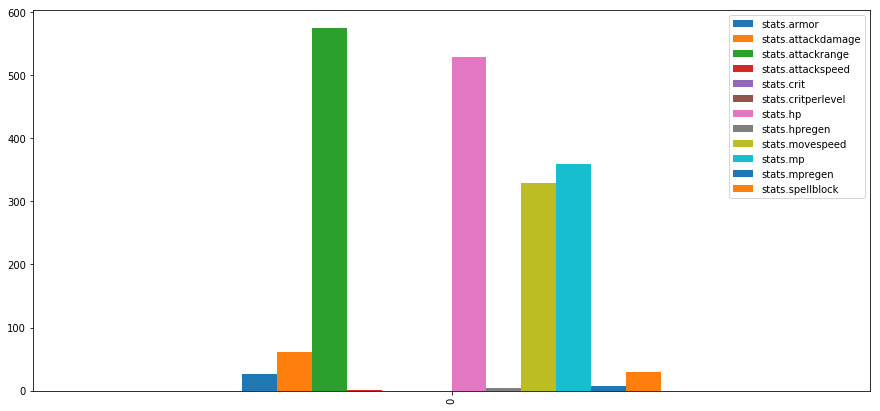

In [22]:
champ_data_df[stats].plot(figsize=(15,7), kind='bar')

In [99]:
q

{'id': 'VarusQ',
 'name': 'Piercing Arrow',
 'description': 'Varus readies and then fires a powerful shot that gains extra range and damage the longer he spends preparing to fire.',
 'tooltip': '<span class="colorFF9900">First Cast:</span> Varus starts drawing back his next shot, gradually increasing its range and damage. While preparing to shoot, Varus\' Movement Speed is slowed by {{ e7 }}%. After {{ e5 }} seconds, Piercing Arrow fails but refunds {{ e4 }}% of its Mana cost.<br /><br /><span class="colorFF9900">Second Cast:</span> Varus fires, dealing <physicalDamage>{{ totaldamagemintooltip }}</physicalDamage> to <physicalDamage>{{ totaldamagemax }} physical damage</physicalDamage>, reduced by {{ e3 }}% per enemy hit (minimum {{ e9 }}%).<br /><br />Piercing Arrow\'s cooldown is reduced by {{ f1 }} seconds if the arrow detonates <span class="colorB829FF">Blight</span> stacks on at least one enemy champion.',
 'leveltip': {'label': ['Maximum Damage',
   'Cooldown',
   'Mana Cost',
   

In [100]:
w

{'id': 'VarusW',
 'name': 'Blighted Quiver',
 'description': "Passive: Varus' basic attacks deal bonus magic damage and apply Blight. Varus' other abilities detonate Blight, dealing magic damage based on the target's maximum Health. Active: Varus empowers his next Piercing Arrow.",
 'tooltip': ' <spellPassive>Passive: </spellPassive>Varus\' basic attacks deal {{ e1 }} <scaleAP>(+{{ a1 }})</scaleAP> bonus magic damage and apply <span class="colorB829FF">Blight</span> for {{ e3 }} seconds (stacks {{ e4 }} times).<br /><br />Varus\' other abilities detonate <span class="colorB829FF">Blight</span>, dealing magic damage equal to {{ e2 }}% <scaleAP>(+{{ a2 }}%)</scaleAP> of the target\'s maximum Health per stack.<br /><br /><spellPassive>Active: </spellPassive>Varus\' next Piercing Arrow deals bonus magic damage equal to <span class="coloreeeeee">{{ f2*100 }}%</span> to <span class="coloreeeeee">{{ f1*100 }}%</span> of the target\'s missing health (scales with Piercing Arrow charge).<br /><b

In [101]:
e

{'id': 'VarusE',
 'name': 'Hail of Arrows',
 'description': "Varus fires a hail of arrows that deal physical damage and desecrate the ground. Desecrated ground slows enemies' Movement Speed and reduces their self healing and regeneration.",
 'tooltip': 'Varus fires a hail of arrows that deals {{ e1 }} <scaleAD>(+{{ a1 }})</scaleAD> physical damage and desecrates the ground for {{ e3 }} seconds.<br /><br />Desecrated Ground slows enemy Movement Speed by {{ e2 }}% and reduces healing effects by {{ e4 }}%.',
 'leveltip': {'label': ['Damage', 'Slow', 'Cooldown'],
  'effect': ['{{ e1 }} -> {{ e1NL }}',
   '{{ effect2amount*-100.000000 }}% -> {{ effect2amountnl*-100.000000 }}%',
   '{{ cooldown }} -> {{ cooldownNL }}']},
 'maxrank': 5,
 'cooldown': [18, 16, 14, 12, 10],
 'cooldownBurn': '18/16/14/12/10',
 'cost': [80, 80, 80, 80, 80],
 'costBurn': '80',
 'datavalues': {},
 'effect': [None,
  [50, 90, 130, 170, 210],
  [25, 30, 35, 40, 45],
  [4, 4, 4, 4, 4],
  [40, 40, 40, 40, 40],
  [300, 3

In [102]:
r

{'id': 'VarusR',
 'name': 'Chain of Corruption',
 'description': 'Varus flings out a damaging tendril of corruption that immobilizes the first enemy champion hit and then spreads towards nearby uninfected champions, immobilizing them too on contact.',
 'tooltip': 'Varus flings out a tendril of corruption that deals {{ e1 }} <scaleAP>(+{{ a1 }})</scaleAP> magic damage and immobilizes the first enemy champion hit for {{ e2 }} seconds.<br /><br />The corruption then spreads towards nearby uninfected enemy champions. If it reaches them, they take the same damage and are also immobilized. Immobilized units gain {{ e4 }} <span class="colorB829FF">Blight</span> stacks over the duration.',
 'leveltip': {'label': ['Damage', 'Cooldown'],
  'effect': ['{{ e1 }} -> {{ e1NL }}', '{{ cooldown }} -> {{ cooldownNL }}']},
 'maxrank': 3,
 'cooldown': [130, 100, 70],
 'cooldownBurn': '130/100/70',
 'cost': [100, 100, 100],
 'costBurn': '100',
 'datavalues': {},
 'effect': [None,
  [150, 200, 250],
  [2, 

In [90]:
champ_data_df['spells'].values[0]

[{'id': 'AatroxQ',
  'name': 'The Darkin Blade',
  'description': 'Aatrox slams his greatsword down, dealing physical damage. He can swing three times, each with a different area of effect.',
  'tooltip': 'Aatrox slams his greatsword down, dealing <physicalDamage>{{ qdamage }} physical damage</physicalDamage>. The Darkin Blade may be re-cast 2 additional times, each one increasing in damage.<br /><br />Each strike can hit with the Edge, briefly knocking enemies up and dealing more damage.',
  'leveltip': {'label': ['Cooldown', 'Damage', 'Total AD Ratio'],
   'effect': ['{{ cooldown }} -> {{ cooldownNL }}',
    '{{ qbasedamage }} -> {{ qbasedamageNL }}',
    '{{ qtotaladratio*100.000000 }}% -> {{ qtotaladrationl*100.000000 }}%']},
  'maxrank': 5,
  'cooldown': [14, 12, 10, 8, 6],
  'cooldownBurn': '14/12/10/8/6',
  'cost': [0, 0, 0, 0, 0],
  'costBurn': '0',
  'datavalues': {},
  'effect': [None,
   [0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0],
   [0, 0, 0

In [66]:
champ_data_df['recommended.ARAM'][0]

[{'type': 'starting',
  'recMath': False,
  'recSteps': False,
  'minSummonerLevel': -1,
  'maxSummonerLevel': -1,
  'showIfSummonerSpell': '',
  'hideIfSummonerSpell': '',
  'appendAfterSection': '',
  'visibleWithAllOf': [''],
  'hiddenWithAnyOf': [''],
  'items': [{'id': '1001', 'count': 1, 'hideCount': False},
   {'id': '2051', 'count': 1, 'hideCount': False},
   {'id': '2003', 'count': 3, 'hideCount': False}]},
 {'type': 'essential',
  'recMath': False,
  'recSteps': False,
  'minSummonerLevel': -1,
  'maxSummonerLevel': -1,
  'showIfSummonerSpell': '',
  'hideIfSummonerSpell': '',
  'appendAfterSection': '',
  'visibleWithAllOf': [''],
  'hiddenWithAnyOf': [''],
  'items': [{'id': '3071', 'count': 1, 'hideCount': False},
   {'id': '3111', 'count': 1, 'hideCount': False},
   {'id': '3053', 'count': 1, 'hideCount': False}]},
 {'type': 'offensive',
  'recMath': False,
  'recSteps': False,
  'minSummonerLevel': -1,
  'maxSummonerLevel': -1,
  'showIfSummonerSpell': '',
  'hideIfSummo

## 데이터 분석

In [3]:
champ_df = pd.read_csv('./data/champ_' + VERSION + '_cleansed.csv')
champ_df.head()

name  info.attack  info.defense  info.difficulty  info.magic  key  \
0   Aatrox            8             4                4           3  266   
1     Ahri            3             4                5           8  103   
2    Akali            5             3                7           8   84   
3  Alistar            6             9                7           5   12   
4    Amumu            2             6                3           8   32   

      partype  stats.armor  stats.armorperlevel  stats.attackdamage  ...  \
0  Blood Well        38.00                 3.25               60.00  ...   
1        Mana        20.88                 3.50               53.04  ...   
2      Energy        23.00                 3.50               62.40  ...   
3        Mana        44.00                 3.50               62.00  ...   
4        Mana        33.00                 3.80               53.38  ...   

   stats.hpregenperlevel  stats.movespeed  stats.mp  stats.mpperlevel  \
0                   1.00              345       0.0               0.0   
1                   0.60              330     418.0              25.0   
2                   0.50              345     200.0               0.0   
3                   0.85              330     350.0              40.0   
4                   0.85              335     287.2              40.0   

   stats.mpregen  stats.mpregenperlevel  stats.spellblock  \
0          0.000                  0.000              32.1   
1          8.000                  0.800              30.0   
2         50.000                  0.000              37.0   
3          8.500                  0.800              32.1   
4          7.382                  0.525              32.1   

   stats.spellblockperlevel                  tags  version  
0                      1.25   ['Fighter', 'Tank']  10.14.1  
1                      0.50  ['Mage', 'Assassin']  10.14.1  
2                      1.25          ['Assassin']  10.14.1  
3                      1.25   ['Tank', 'Support']  10.14.1  
4                      1.25      ['Tank', 'Mage']  10.14.1  

[5 rows x 29 columns]

In [4]:
print('챔피언 수: ', len(champ_df))
print('속성: ', len(champ_df.columns), '\n', champ_df.columns)

챔피언 수:  148
속성:  29 
 Index(['name', 'info.attack', 'info.defense', 'info.difficulty', 'info.magic',
       'key', 'partype', 'stats.armor', 'stats.armorperlevel',
       'stats.attackdamage', 'stats.attackdamageperlevel', 'stats.attackrange',
       'stats.attackspeed', 'stats.attackspeedperlevel', 'stats.crit',
       'stats.critperlevel', 'stats.hp', 'stats.hpperlevel', 'stats.hpregen',
       'stats.hpregenperlevel', 'stats.movespeed', 'stats.mp',
       'stats.mpperlevel', 'stats.mpregen', 'stats.mpregenperlevel',
       'stats.spellblock', 'stats.spellblockperlevel', 'tags', 'version'],
      dtype='object')


### PARTYPE

In [5]:
champ_partype = {}
partype_list = champ_df['partype'].unique()
print('**partype list**')
print(partype_list, '\n')

for pt in partype_list:
    champ_partype[pt] = champ_df.loc[champ_df['partype'] == pt]
    print('{0:<15}: {1:3}'.format(pt, len(champ_partype[pt])))
    if len(champ_partype[pt]) < 10:
        print(champ_partype[pt].name.values)
    print()

**partype list**
['Blood Well' 'Mana' 'Energy' 'None' 'Rage' 'Courage' 'Shield' 'Fury'
 'Ferocity' 'Heat' 'Grit' 'Crimson Rush' 'Flow'] 

Blood Well     :   1
['Aatrox']

Mana           : 125

Energy         :   5
['Akali' 'Kennen' 'Lee Sin' 'Shen' 'Zed']

None           :   5
['Dr. Mundo' 'Garen' 'Katarina' 'Riven' 'Zac']

Rage           :   2
['Gnar' "Rek'Sai"]

Courage        :   1
['Kled']

Shield         :   1
['Mordekaiser']

Fury           :   3
['Renekton' 'Shyvana' 'Tryndamere']

Ferocity       :   1
['Rengar']

Heat           :   1
['Rumble']

Grit           :   1
['Sett']

Crimson Rush   :   1
['Vladimir']

Flow           :   1
['Yasuo']



In [ ]:
champ_party

# Item

In [15]:
#champion info load
item_req = requests.get('http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/item.json')
item_ls = list(item_req.json()['data'].keys())
item_df = pd.DataFrame()

for i in range(len(item_ls)):
    pre_df = json_normalize(item_req.json()['data'][item_ls[i]])
    item_df = item_df.append(pre_df)
    
# item_df.to_csv('./data/item_' + VERSION + '.csv')
item_df.head()

C:\Users\LG\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


colloq consumeOnFull consumed  depth  \
0      ;           NaN      NaN    NaN   
0      ;           NaN      NaN    NaN   
0      ;           NaN      NaN    NaN   
0      ;           NaN      NaN    2.0   
0      ;           NaN      NaN    NaN   

                                         description effect.Effect10Amount  \
0  <groupLimit>Limited to 1 pair of boots.</group...                   NaN   
0  <stats><mana>+25% Base Mana Regen </mana></stats>                   NaN   
0             <stats>+50% Base Health Regen </stats>                   NaN   
0                         <stats>+380 Health</stats>                   NaN   
0         <stats>+20% Critical Strike Chance</stats>                   NaN   

  effect.Effect11Amount effect.Effect12Amount effect.Effect13Amount  \
0                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   
0                   NaN                   NaN                   NaN   

  effect.Effect14Amount  ... stats.FlatHPRegenMod stats.FlatMPPoolMod  \
0                   NaN  ...                  NaN                 NaN   
0                   NaN  ...                  NaN                 NaN   
0                   NaN  ...                  NaN                 NaN   
0                   NaN  ...                  NaN                 NaN   
0                   NaN  ...                  NaN                 NaN   

  stats.FlatMagicDamageMod stats.FlatMovementSpeedMod  \
0                      NaN                       25.0   
0                      NaN                        NaN   
0                      NaN                        NaN   
0                      NaN                        NaN   
0                      NaN                        NaN   

  stats.FlatPhysicalDamageMod stats.FlatSpellBlockMod  \
0                         NaN                     NaN   
0                         NaN                     NaN   
0                         NaN                     NaN   
0                         NaN                     NaN   
0                         NaN                     NaN   

  stats.PercentAttackSpeedMod stats.PercentLifeStealMod  \
0                         NaN                       NaN   
0                         NaN                       NaN   
0                         NaN                       NaN   
0                         NaN                       NaN   
0                         NaN                       NaN   

  stats.PercentMovementSpeedMod              tags  
0                           NaN           [Boots]  
0                           NaN       [ManaRegen]  
0                           NaN     [HealthRegen]  
0                           NaN          [Health]  
0                           NaN  [CriticalStrike]  

[5 rows x 61 columns]

In [19]:
#champion info load
item_req = requests.get('http://ddragon.leagueoflegends.com/cdn/' + VERSION + '/data/en_US/item.json')
item_ls = []

for i in list(range(0,10000)):
    try:
        a = item_req.json()['data'][str(i)]
        item_ls.append(str(i))
    except:
        pass
    
item_df = pd.DataFrame()

for item_id in item_ls:
    try:
        name = item_req.json()['data'][item_id]['name']
    except:
        name = np.nan
        
    try:
        colloq = item_req.json()['data'][item_id]['colloq']
    except:
        colloq = np.nan
    
    try:
        upper_item = item_req.json()['data'][item_id]['into']
    except:
        upper_item = np.nan
        
    try:
        lower_item = item_req.json()['data'][item_id]['from']
    except:
        lower_item = np.nan
        
    try:
        explain = item_req.json()['data'][item_id]['plaintext']
    except:
        explain = np.nan
    
    try:
        buy_price = item_req.json()['data'][item_id]['gold']['base']
    except:
        buy_price = np.nan
        
    try:
        sell_price = item_req.json()['data'][item_id]['gold']['sell']
    except:
        sell_price = np.nan
    
    try:
        description = item_req.json()['data'][item_id]['description']
    except:
        description = np.nan
        
    try:
        tag = item_req.json()['data'][item_id]['tags']
    except:
        tag = np.nan
        
    try:
        stat = item_req.json()['data'][item_id]['stats']
    except:
        stat = np.nan
        
    try:
        effect = item_req.json()['data'][item_id]['effect']
    except:
        effect = np.nan
    
    pre_df = pd.DataFrame({'item_id' : [item_id],
                           'name' : [name],
                           'colloq' : [colloq],
                           'upper_item' : [upper_item],
                           'lower_item' : [lower_item],
                           'explain' : [explain],
                           'buy_price' : [buy_price],
                           'sell_price' : [sell_price],
                           "description" : [description],
                           'tag' : [tag],
                           'stat' : [stat],
                           'effect' : [effect]
                           
                          })
    item_df = item_df.append(pre_df)
    
item_df.to_csv('./data/item_' + VERSION + '.csv')
item_df.head()

item_id               name colloq  \
0    1001     Boots of Speed      ;   
0    1004       Faerie Charm      ;   
0    1006  Rejuvenation Bead      ;   
0    1011       Giant's Belt      ;   
0    1018   Cloak of Agility      ;   

                                         upper_item lower_item  \
0  [3006, 3047, 3020, 3158, 3111, 3117, 3009, 4001]        NaN   
0                          [3028, 3070, 3073, 3114]        NaN   
0                          [3077, 3801, 3194, 4401]        NaN   
0                    [3083, 3084, 3022, 3143, 3742]     [1028]   
0                          [3086, 3095, 3031, 3508]        NaN   

                             explain  buy_price  sell_price  \
0  Slightly increases Movement Speed        300         210   
0      Slightly increases Mana Regen        125          88   
0    Slightly increases Health Regen        150         105   
0           Greatly increases Health        600         700   
0   Increases critical strike chance        800         560   

                                         description               tag  \
0  <groupLimit>Limited to 1 pair of boots.</group...           [Boots]   
0  <stats><mana>+25% Base Mana Regen </mana></stats>       [ManaRegen]   
0             <stats>+50% Base Health Regen </stats>     [HealthRegen]   
0                         <stats>+380 Health</stats>          [Health]   
0         <stats>+20% Critical Strike Chance</stats>  [CriticalStrike]   

                           stat effect  
0  {'FlatMovementSpeedMod': 25}    NaN  
0                            {}    NaN  
0                            {}    NaN  
0        {'FlatHPPoolMod': 380}    NaN  
0    {'FlatCritChanceMod': 0.2}    NaN